In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NNSingleFeatureModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/{key}.pkl')
    return raw[key]

In [3]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

def save_model_with_config(train_config, sub_model_key, **kwargs):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    f = f"{path}/{prefix}{sub_model_key}.pth"
    torch.save(kwargs, f)

In [15]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [5]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [57]:
train_config = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_prefix' : "TRY_2_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t5_models",
    'device' : 'cpu',
}

In [7]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']
y_test = y_test[y_cols]

Loading data to cache for: sample_test
CPU times: user 408 ms, sys: 381 ms, total: 789 ms
Wall time: 603 ms


In [25]:
model_configs = {
    'y_INCLINATION': { 'feature_index': X_test.columns.get_loc('X_INCLINATION_1') },
    'y_ECCENTRICITY': { 'feature_index': X_test.columns.get_loc('X_ECCENTRICITY_1') },
    'y_MEAN_MOTION': { 'feature_index': X_test.columns.get_loc('X_MEAN_MOTION_1') },
    'y_RA_OF_ASC_NODE_REG': { 'feature_index': X_test.columns.get_loc('X_RA_OF_ASC_NODE_1') },
    'y_ARG_OF_PERICENTER_REG': { 'feature_index': X_test.columns.get_loc('X_ARG_OF_PERICENTER_1') },
    'y_REV_MA_REG': { 'feature_index': X_test.columns.get_loc('X_MEAN_ANOMALY_1') },
}

Loading existing model


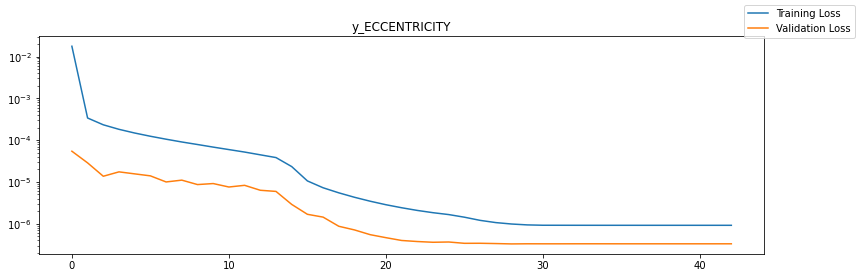

Epoch 43
    Test set MAE (L1) loss: 0.000335897304149887
    Test set MSE (L2) loss: 2.999693013400028e-07
Test - Ground Truth (normalized):


,y_ECCENTRICITY
113221,0.0158508
235868,0.0164672
55816,0.0150940
178429,0.0210316
176507,0.0231884
...,...
290077,0.0447680
193135,0.0217492
213954,0.0192580
213948,0.0180456


Test - Prediction (normalized):


,y_ECCENTRICITY
113221,0.0156000294
235868,0.0166503880
55816,0.0149663817
178429,0.0207770951
176507,0.0258183014
...,...
290077,0.0444406457
193135,0.0220001414
213954,0.0181605089
213948,0.0166630503


Test - X (normalized):


,X_ECCENTRICITY_1
113221,0.0156660
235868,0.0167728
55816,0.0150696
178429,0.0208620
176507,0.0258500
...,...
290077,0.0445760
193135,0.0220912
213954,0.0182516
213948,0.0167484


[(9.143375999363248e-07, 3.2989010634310034e-07), (9.142960833106214e-07, 3.298838961995898e-07), (9.140231782918386e-07, 3.2987482256885414e-07), (9.143069299554541e-07, 3.298445818700202e-07), (9.142103758652778e-07, 3.299049993188419e-07)]


In [156]:
# Create or load all new sub models here if needed.
all_models = {}
# for sub_key in model_configs.keys():
for sub_key in ['y_REV_MA_REG']:
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    tl, vl = zip(*mean_losses)

    fig,ax = plt.subplots(figsize=(13,4))
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
    ax.set_yscale('log')
    fig.legend()
    plt.show()
    
    trained_model = model
    sample_idx = random.sample(list(X_test.index), 10000)
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx][[sub_key]]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    print("Test - Ground Truth (normalized):")
    display(y_sample)
    print("Test - Prediction (normalized):")
    display(y_sample_pred_df)
    print("Test - X (normalized):")
    display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1].values - y_sample_pred_df.values)
    print(mean_losses[-5:])

AdamW optimizer
Decrease learning rate slowly over time
Decrease weight decay if both training and validation are decreasing similarly